In [1]:
import numpy as np
import jax; jax.config.update('jax_platform_name', 'cpu')
import jax.numpy as jnp

import crayopt

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
SEED = 112233

N_STEPS = 2048

N_INITIAL_GUESSES_TRAIN = 32
N_INITIAL_GUESSES_VAL = 32
N_INITIAL_GUESSES_TEST = 1024

BUDGET = 4096
BUDGET_SQRT = int(np.sqrt(BUDGET))
BUDGET_CBRT = int(np.cbrt(BUDGET))
BUDGET_QDRT = int(np.power(BUDGET, 0.25))

In [3]:
rng = jax.random.PRNGKey(SEED)
target = crayopt.functions.rosenbrock_2d

target_grad = jax.jit(jax.grad(target))

In [4]:
from collections import namedtuple
Task = namedtuple('Task', ['method', 'parameters'])

optimizers = dict(
    adam=Task(
        method=crayopt.gradient.adam,
        parameters=dict(
            learning_rate=np.geomspace(1e-4, 1e-2, num=BUDGET_CBRT),
            beta1=1 - np.geomspace(1e-3, 1, num=BUDGET_CBRT + 1)[:-1],
            beta2=1 - np.geomspace(1e-4, 1, num=BUDGET_CBRT + 1)[:-1],
            eps=[1e-8]
        )
    ),

    laprop=Task(
        method=crayopt.gradient.laprop,
        parameters=dict(
            learning_rate=np.geomspace(1e-4, 1e-2, num=BUDGET_CBRT),
            mu=1 - np.geomspace(1e-3, 1, num=BUDGET_CBRT + 1)[:-1],
            nu=1 - np.geomspace(1e-4, 1, num=BUDGET_CBRT + 1)[:-1],
            eps=[1e-8]
        )
    ),
    
    adabelief=Task(
        method=crayopt.gradient.adabelief,
        parameters=dict(
            learning_rate=np.geomspace(1e-4, 1e-2, num=BUDGET_CBRT),
            beta1=1 - np.geomspace(1e-3, 1, num=BUDGET_CBRT + 1)[:-1],
            beta2=1 - np.geomspace(1e-4, 1, num=BUDGET_CBRT + 1)[:-1],
            eps=[1e-8]
        )
    ),

    yogi=Task(
        method=crayopt.gradient.yogi,
        parameters=dict(
            learning_rate=np.geomspace(1e-2, 1, num=BUDGET_CBRT),
            beta1=1 - np.geomspace(1e-3, 1, num=BUDGET_CBRT + 1)[:-1],
            beta2=1 - np.geomspace(1e-4, 1, num=BUDGET_CBRT + 1)[:-1],
            eps=[1e-8]
        )
    ),
    
    adap=Task(
        method=crayopt.gradient.adap,
        parameters=dict(
            learning_rate=np.geomspace(1e-2, 1, num=BUDGET_QDRT),
            rho=1 - np.geomspace(1e-3, 1, num=BUDGET_QDRT + 1)[:-1],
            nu_slow=1 - np.geomspace(1e-3, 1, num=BUDGET_QDRT + 1)[:-1],
            nu_fast=1 - np.geomspace(1e-3, 1, num=BUDGET_QDRT + 1)[:-1],
            eps=[1e-8]
        )
    ),
)

In [5]:
def get_optimizer(method):
    @jax.jit
    def optimizer(x0, *args):
        opt = method(*args)
        state0 = opt.initial_state(x0)

        def step(carry, _):
            x, s = carry

            df = target_grad(x)
            x_, s_ = opt(x, df, s)

            return (x_, s_), x_

        _, xs = jax.lax.scan(
            step, init=(x0, state0), length=N_STEPS, xs=None
        )

        return xs

    return optimizer

In [6]:
import inspect

for method_name in optimizers:
    method = optimizers[method_name].method
    parameters = optimizers[method_name].parameters
    
    keys_signature = list(inspect.signature(method).parameters)
    keys_parameters = list(parameters)
    
    if keys_parameters != keys_signature:
        raise ValueError(
            'Provided parameters (%s) do not correspond to the method signature (%s)' % (
                ', '.join(keys_parameters), ', '.join(keys_signature),
            )
        )

In [7]:
search_domain = jnp.array(target.search_domain())

def get_initial_guesses(rng, n):
    u = jax.random.uniform(rng, shape=(n, search_domain.shape[1]))
    return u * (search_domain[:, 1] - search_domain[:, 0])[None, :] + search_domain[None, :, 0]

rng, rng_train, rng_test = jax.random.split(rng, 3)

X0_train = get_initial_guesses(rng_train, N_INITIAL_GUESSES_TRAIN)
F0_train = target(X0_train)

X0_test = get_initial_guesses(rng_test, N_INITIAL_GUESSES_TEST)
F0_test = target(X0_test)

solution = jnp.array(target.optimum(), dtype=jnp.float32)

In [8]:
def get_traces(optimizer, xs0, *params):
    return jnp.stack([
        optimizer(x0, *params)
        for x0 in xs0
    ], axis=0)

def loss(optimizer, xs0, *params):
    f0s = target(xs0)
    fs = target(get_traces(optimizer, xs0, *params)[:, -1])
    
    return jnp.mean(
        jnp.log(fs) - jnp.log(f0s)
    )

In [9]:
best_parameters = dict()

train_parameters = dict()

train_traces = dict()
train_losses = dict()
train_curves = dict()

test_traces = dict()
test_curves = dict()

for method_name in tqdm(optimizers):
    optimizer = get_optimizer(optimizers[method_name].method)
    parameters_grid = np.stack(
        np.meshgrid(*[
            v for k, v in optimizers[method_name].parameters.items()
        ]),
        axis=-1
    )
    
    parameters = parameters_grid.reshape(-1, parameters_grid.shape[-1])
    
    losses = np.zeros(parameters.shape[0], dtype=np.float32)
    
    for i in tqdm(range(parameters.shape[0]), desc=method_name):
        losses[i] = loss(optimizer, X0_train, *parameters[i])
    
    losses = np.where(np.isfinite(losses), losses, 1000)
    
    best_indx = np.argmin(losses)
    best_parameters[method_name] = parameters[best_indx]
    
    train_traces[method_name] = get_traces(optimizer, X0_train, *best_parameters[method_name])
    train_curves[method_name] = target(train_traces[method_name])
    
    train_parameters[method_name] = parameters
    train_losses[method_name] = losses
    
    test_traces[method_name] = get_traces(optimizer, X0_test, *best_parameters[method_name])
    test_curves[method_name] = target(test_traces[method_name])

  0%|          | 0/5 [00:00<?, ?it/s]

adam:   0%|          | 0/4096 [00:00<?, ?it/s]

laprop:   0%|          | 0/4096 [00:00<?, ?it/s]

adabelief:   0%|          | 0/4096 [00:00<?, ?it/s]

yogi:   0%|          | 0/4096 [00:00<?, ?it/s]

adap:   0%|          | 0/4096 [00:00<?, ?it/s]

Text(0.5, 0, 'steps')

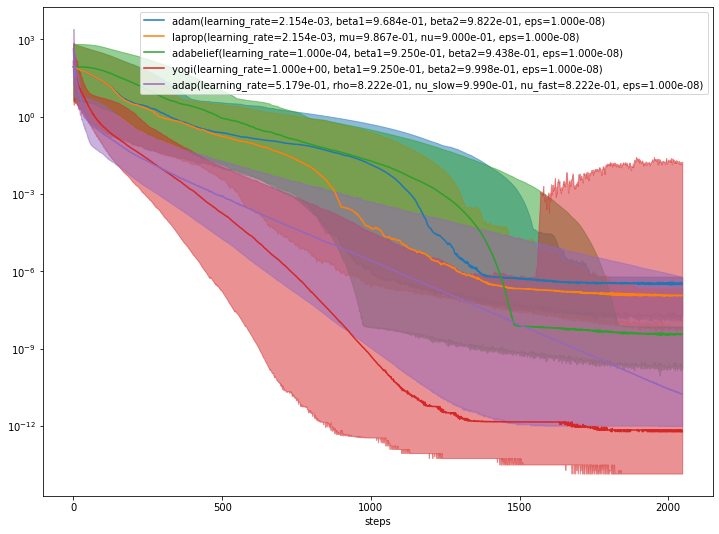

In [10]:
plt.figure(figsize=(12, 9))
for i, method_name in enumerate(optimizers):
    label = '{method}({parameters})'.format(
        method=method_name,
        parameters=', '.join([
            '%s=%.3e' % (k, v)
            for k, v in zip(optimizers[method_name].parameters, best_parameters[method_name])
        ])
    )
    low, med, high = np.quantile(test_curves[method_name], q=(0.1, 0.5, 0.9), axis=0)
    plt.fill_between(
        np.arange(N_STEPS), low, high,
        alpha=0.5, color=plt.cm.tab10(i)
    )
    plt.plot(
        np.arange(N_STEPS), med,
        color=plt.cm.tab10(i), label=label
    )

plt.legend(loc='upper right')
plt.yscale('log')
plt.xlabel('steps')

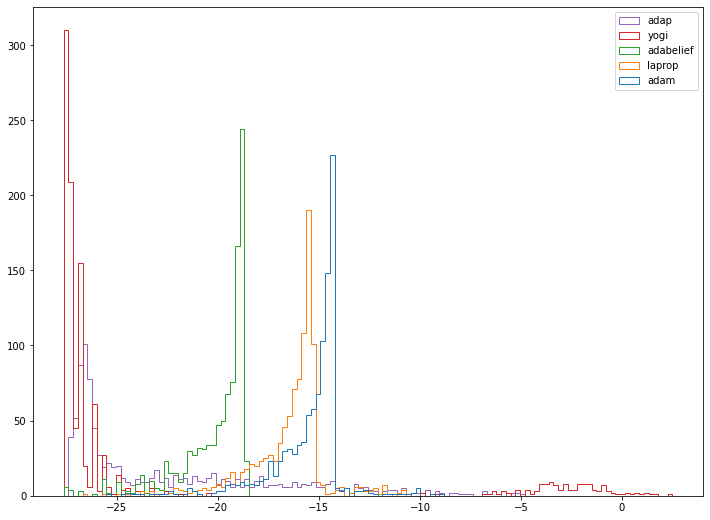

In [11]:
plt.figure(figsize=(12, 9))
_ = plt.hist(
    [jnp.log(test_curves[name][:, -1] + 1e-12) for name in test_curves],
    label=[name for name in test_curves],
    bins=128, histtype='step'
)
plt.legend()